<a href="https://colab.research.google.com/github/AnnaBujniewicz/semester_project/blob/main/7_Backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backtest

In [ ]:
# importing the needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# importing and clenaing up the database
backtest_base = pd.read_csv("https://raw.githubusercontent.com/AnnaBujniewicz/semester_project/main/data/alxn_pred.csv")
backtest_base.drop(["ALXN-1", "Unnamed: 0"] , axis = 1, inplace=True)
backtest_base = backtest_base.set_index("date")
backtest_base.head()

,ALXN,pred_title,pred_sent,pred_rf,pred_lr,pred_nn
date,,,,,,
2020-07-14,108.570000,107.122723,110.663231,105.559075,107.177562,100.320844
2020-07-15,111.129997,103.183073,109.078313,109.445380,108.684392,101.307027
2020-07-16,109.470001,113.361546,110.262817,109.475753,111.189249,102.930600
2020-07-17,109.239998,113.361542,109.768310,111.377206,109.565008,101.889955
2020-07-20,109.540001,104.536600,111.145223,110.046088,109.339959,101.740495


In [ ]:
# creating columns showing daily change for alexion stock data and each predictive model
for col in backtest_base.columns:
  backtest_base["change_{column}".format(column = col)] = backtest_base[col].diff()
backtest_base.dropna(inplace=True)

In [ ]:
# making a small function that will let us assign the positions
def assign_sign(row):    
  if row > 0:
      row = -1
  else:
      row = 1
  return row

In [ ]:
# applying the function to daily differences
for col in backtest_base.columns[6:]:
  backtest_base[col] = backtest_base[col].apply(lambda x: assign_sign(x))

In [ ]:
# checking if the changes for predictive models are identical as the changes in stock data
for col in backtest_base.columns[7:]:
  backtest_base["comp_{column}".format(column = col)] = np.where(backtest_base['change_ALXN'] == backtest_base[col], True, False)

In [ ]:
# measuring the accuracy for each model
for col in backtest_base.columns[12:]:
  print("Accuracy for {column}".format(column = col))
  print("{}%".format(backtest_base[col].value_counts(normalize=True)[1]*100))

Accuracy for comp_change_pred_title
55.208333333333336%
Accuracy for comp_change_pred_sent
54.166666666666664%
Accuracy for comp_change_pred_rf
43.75%
Accuracy for comp_change_pred_lr
43.75%
Accuracy for comp_change_pred_nn
43.75%


In [ ]:
# shifting the predictions to use them for trading test
for col in backtest_base.columns[7:11]:
  backtest_base[col] = backtest_base[col].shift(-1)
backtest_base.dropna(inplace=True)

In [ ]:
# setting the initial capital
initial_capital= float(100000.0)

# create a dataframe
trading = pd.DataFrame(index=backtest_base.index).fillna(0.0)

for col in backtest_base.columns[7:12]:
  trading[col] = backtest_base[col]*backtest_base["ALXN"]*100

In [ ]:
# calculating the daily cash flows for the investment
trading["buy_n_hold"] = 0
trading["buy_n_hold"] = trading["buy_n_hold"].astype(float)
trading["buy_n_hold"][0] = backtest_base["ALXN"][0]*-100
trading["buy_n_hold"][-1] = backtest_base["ALXN"][-1]*100

In [ ]:
# filling a dataframe with the positions
diff = pd.DataFrame(index=backtest_base.index).fillna(0.0)
for col in backtest_base.columns[7:12]:
  diff[col] = backtest_base[col].diff()

diff["buy_n_hold"] = 0
diff["buy_n_hold"] = diff["buy_n_hold"].astype(float)
diff["buy_n_hold"][0] = -1
diff["buy_n_hold"][-1] = 1

In [ ]:
# creating a portfolio dataframe for each strategy, including buy and hold
portfolio = pd.DataFrame(index=trading.columns).fillna(0.0)
# summing up the daily cash flows
holdings = []
for col in trading.columns:  
  holdings.append(trading[col].sum())
portfolio["holdings"] = holdings
# finding the final number of cash
cash = []
for col in trading.columns: 
 cash.append(initial_capital - ((diff[col]*100).multiply(backtest_base['ALXN'], axis=0)).sum().cumsum())
portfolio["cash"] = cash
portfolio["cash"] = portfolio["cash"].astype(float)
# finding the total ammount of money and the percentage returns
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = (portfolio["total"]/initial_capital)-1
portfolio

,holdings,cash,total,returns
change_pred_title,76704.999542,101066.000366,177770.999908,0.77771
change_pred_sent,6569.001007,74755.998230,81324.999237,-0.18675
change_pred_rf,-112797.000885,104612.001038,-8184.999847,-1.08185
change_pred_lr,70856.999969,79529.995728,150386.995697,0.50387
change_pred_nn,50386.995697,100048.002625,150434.998322,0.50435
buy_n_hold,1180.000305,98819.999695,100000.000000,0.00000


In [ ]:
# creating the dataframe with daily returns for further visualization
returns = pd.DataFrame()
for col in trading.columns:
  returns[col] = trading[col].cumsum()
cash = pd.DataFrame()
for col in trading.columns: 
 cash[col] = (initial_capital - ((diff[col]*100).multiply(backtest_base['ALXN'], axis=0)).cumsum())
for col in trading.columns: 
  returns[col] = returns[col]+cash[col]

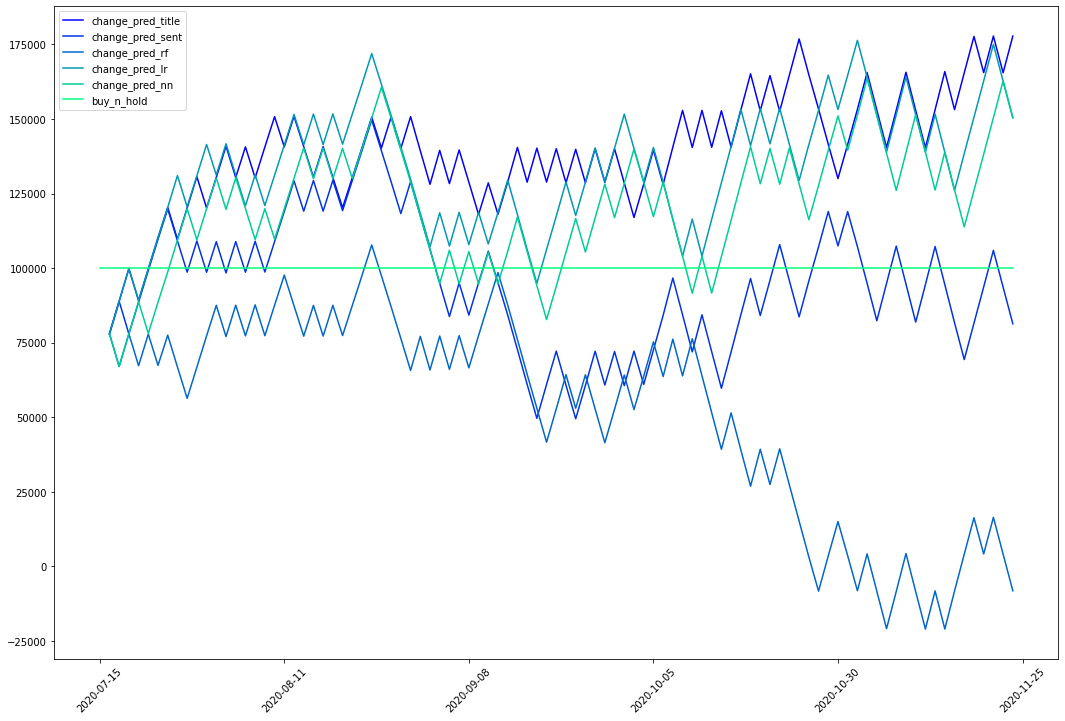

In [ ]:
# creating the visualization of daily returns for each appraoch
plt.figure(figsize=(18,12))
colors = plt.cm.winter(np.linspace(0,1,6))
plt.xticks(rotation=45, ticks=[0, int(len(returns)*0.2),int(len(returns)*0.4),int(len(returns)*0.6),int(len(returns)*0.8),int(len(returns))], labels = [returns.index[0],returns.index[int(len(returns)*0.2)],returns.index[int(len(returns)*0.4)],returns.index[int(len(returns)*0.6)],returns.index[int(len(returns)*0.8)], returns.index[-1]])
for i in range(6):
  plt.plot(returns.iloc[:,i], color = colors[i])
plt.legend(returns.columns)
plt.show()